In [11]:
import pandas as pd
import numpy as np

class ForexIndicators:
    """Minimalist forex technical indicators calculator."""
    
    def __init__(self, df: pd.DataFrame):
        """
        Args:
            df: DataFrame with columns: Open, High, Low, Close, Volume
        """
        self.df = df.copy()
        self.o = df['Open']
        self.h = df['High']
        self.l = df['Low']
        self.c = df['Close']
        self.v = df.get('Vol', pd.Series(0, index=df.index))
    
    # === TREND ===
    def sma(self, period: int = 20) -> pd.Series:
        return self.c.rolling(period).mean()
    
    def ema(self, period: int = 20) -> pd.Series:
        return self.c.ewm(span=period, adjust=False).mean()
    
    def macd(self, fast: int = 12, slow: int = 26, signal: int = 9) -> pd.DataFrame:
        ema_fast = self.c.ewm(span=fast, adjust=False).mean()
        ema_slow = self.c.ewm(span=slow, adjust=False).mean()
        macd_line = ema_fast - ema_slow
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        histogram = macd_line - signal_line
        return pd.DataFrame({'macd': macd_line, 'signal': signal_line, 'histogram': histogram})
    
    # === MOMENTUM ===
    def rsi(self, period: int = 14) -> pd.Series:
        delta = self.c.diff()
        gain = delta.where(delta > 0, 0).rolling(period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    def stochastic(self, k_period: int = 14, d_period: int = 3) -> pd.DataFrame:
        lowest_low = self.l.rolling(k_period).min()
        highest_high = self.h.rolling(k_period).max()
        k = 100 * (self.c - lowest_low) / (highest_high - lowest_low)
        d = k.rolling(d_period).mean()
        return pd.DataFrame({'%K': k, '%D': d})
    
    def momentum(self, period: int = 10) -> pd.Series:
        return self.c.diff(period)
    
    # === VOLATILITY ===
    def bollinger_bands(self, period: int = 20, std_dev: float = 2) -> pd.DataFrame:
        sma = self.c.rolling(period).mean()
        std = self.c.rolling(period).std()
        return pd.DataFrame({
            'upper': sma + (std * std_dev),
            'middle': sma,
            'lower': sma - (std * std_dev)
        })
    
    def atr(self, period: int = 14) -> pd.Series:
        tr = pd.concat([
            self.h - self.l,
            (self.h - self.c.shift()).abs(),
            (self.l - self.c.shift()).abs()
        ], axis=1).max(axis=1)
        return tr.rolling(period).mean()
    
    # === VOLUME ===
    def obv(self) -> pd.Series:
        direction = np.sign(self.c.diff())
        return (self.v * direction).cumsum()
    
    def vwap(self) -> pd.Series:
        typical_price = (self.h + self.l + self.c) / 3
        return (typical_price * self.v).cumsum() / self.v.cumsum()
    
    # === ADX (TREND STRENGTH) ===
    def adx(self, period: int = 14) -> pd.DataFrame:
        tr = pd.concat([
            self.h - self.l,
            (self.h - self.c.shift()).abs(),
            (self.l - self.c.shift()).abs()
        ], axis=1).max(axis=1)
        
        plus_dm = self.h.diff()
        minus_dm = -self.l.diff()
        plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
        minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
        
        atr = tr.ewm(span=period, adjust=False).mean()
        plus_di = 100 * (plus_dm.ewm(span=period, adjust=False).mean() / atr)
        minus_di = 100 * (minus_dm.ewm(span=period, adjust=False).mean() / atr)
        
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
        adx = dx.ewm(span=period, adjust=False).mean()
        
        return pd.DataFrame({'+DI': plus_di, '-DI': minus_di, 'ADX': adx})
    
    # === CONVENIENCE ===
    def add_all(self) -> pd.DataFrame:
        """Add all indicators to dataframe."""
        result = self.df.copy()
        
        # Trend
        result['SMA_20'] = self.sma(20)
        result['EMA_20'] = self.ema(20)
        macd = self.macd()
        result = pd.concat([result, macd.add_prefix('MACD_')], axis=1)
        
        # Momentum
        result['RSI_14'] = self.rsi(14)
        stoch = self.stochastic()
        result = pd.concat([result, stoch.add_prefix('STOCH_')], axis=1)
        
        # Volatility
        bb = self.bollinger_bands()
        result = pd.concat([result, bb.add_prefix('BB_')], axis=1)
        result['ATR_14'] = self.atr(14)
        
        # Trend strength
        adx = self.adx()
        result = pd.concat([result, adx.add_prefix('ADX_')], axis=1)
        
        return result



In [12]:
# === USAGE ===
if __name__ == "__main__":
    # Assuming df already exists with OHLC data
    df = pd.read_csv('USDJPY_H4.csv')
    
    indicators = ForexIndicators(df)
    
    # Individual indicators
    rsi = indicators.rsi(14)
    macd = indicators.macd()
    bb = indicators.bollinger_bands()
    
    # Or add all at once
    df_with_indicators = indicators.add_all()

In [13]:
df_with_indicators.iloc[:, -10:]  # Display last 10 columns with indicators

,RSI_14,STOCH_%K,STOCH_%D,BB_upper,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.466552,0.000000,100.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.476947,0.000000,100.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.744381,0.000000,100.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.545309,1.143975,98.172120
...,...,...,...,...,...,...,...,...,...,...
13986,67.430639,79.189687,72.805402,115.249639,114.95765,114.665661,0.148143,18.568383,14.266485,19.615493
13987,68.757396,83.241252,78.330264,115.267564,114.96950,114.671436,0.150071,20.551282,12.131434,20.435079
13988,64.803050,80.847145,81.092695,115.281426,114.98105,114.680674,0.145214,18.957054,11.190360,21.145387
13989,52.097429,66.666667,76.918355,115.279618,114.99315,114.706682,0.148857,15.468088,16.142089,18.610299


In [14]:
df_with_indicators.to_csv('USDJPY_H4_with_indicators.csv', index=False)

In [15]:
df_new = df_with_indicators.copy().iloc[20:-20,:]  # Remove first 20 and last 20 rows

In [16]:
df_new.head()

,Date,Time,Open,High,Low,Close,Tick,Vol,Spread,SMA_20,...,RSI_14,STOCH_%K,STOCH_%D,BB_upper,BB_middle,BB_lower,ATR_14,ADX_+DI,ADX_-DI,ADX_ADX
20,2013.01.07,4:00:00,88.054,88.172,87.682,87.776,15805,0.0,5,87.47755,...,57.390451,61.995104,75.071399,88.353561,87.47755,86.601539,0.383000,21.608311,14.988387,53.500638
21,2013.01.07,8:00:00,87.777,87.906,87.621,87.874,19020,0.0,5,87.51380,...,60.045366,67.992656,69.645043,88.392564,87.51380,86.635036,0.384429,19.446532,15.630181,47.817888
22,2013.01.07,12:00:00,87.877,87.955,87.716,87.778,17750,0.0,5,87.54090,...,58.528111,62.117503,64.035088,88.417018,87.54090,86.664782,0.392286,19.539695,14.250665,43.529167
23,2013.01.07,16:00:00,87.779,87.872,87.651,87.685,16682,0.0,5,87.57360,...,63.502399,56.425949,62.178703,88.417825,87.57360,86.729375,0.378286,17.858034,15.555488,38.644086
24,2013.01.07,20:00:00,87.685,87.843,87.351,87.456,10560,0.0,9,87.58620,...,58.068697,40.555907,53.033119,88.414572,87.58620,86.757828,0.391071,14.624834,23.778807,36.669703


In [17]:
import matplotlib.pyplot as plt

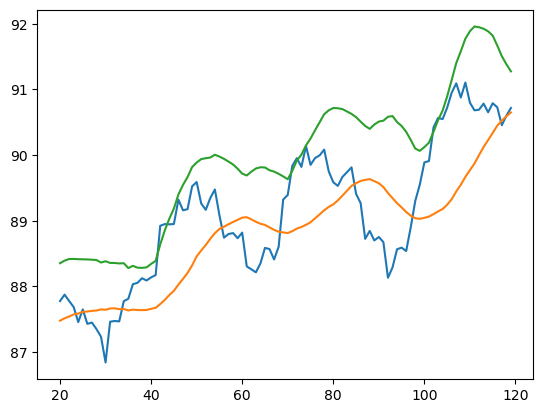

In [19]:
plt.plot(df_new['Close'].iloc[:100], label='Close Price')
plt.plot(df_new['SMA_20'].iloc[:100], label='SMA 20')
plt.plot(df_new['BB_upper'].iloc[:100], label='Bollinger Upper Band')

In [20]:
test_df = df_new.copy().iloc[:100]